In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cohlib.utils import gamma_root
gamma_root()

'/projectnb/stephenlab/jtauber/cohlib/hydra/gammas'

In [3]:
def plot_jvo(jax_output, old_output, k, pltlim, suptitle, showyx=True):
    if pltlim is None:
        all_output = jnp.concatenate([jax_output[:,k].real, jax_output[:,k].imag, 
            old_output[:,k].real, old_output[:,k].imag])
        pltlim = all_output.max() * 1.2

    yxline = jnp.linspace(-pltlim, pltlim, 100)
    fig, ax = plt.subplots(1,2, figsize=(8,3))
    ax[0].plot(jax_output[:,k].real, old_output[:,k].real, '.')
    ax[0].set_title('Real')

    ax[1].plot(jax_output[:,k].imag, old_output[:,k].imag, '.')
    ax[1].set_title('Imag')

    for i in range(2):
        ax[i].set_xlim([-pltlim, pltlim])
        ax[i].set_ylim([-pltlim, pltlim])
        if showyx is True:
            ax[i].plot(yxline, yxline, 'k')
        ax[i].set_xlabel('Jax')
        ax[i].set_ylabel('Old')

    fig.suptitle(suptitle)
    plt.tight_layout()

In [4]:
import os
import shutil
from pathlib import Path
import jax.numpy as jnp
import jax.random as jr
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

from cohlib.jax.ts_gaussian import load_results

In [5]:
def clean_dir(path):
    paths_to_remove = []
    _dir = Path(path)
    for i, exp in enumerate(_dir.glob('*')):
        exp_path = Path(exp)
        contents = []
        for f in exp_path.glob('*'):
            contents.append(os.path.split(f)[1])
        if 'res.pickle' not in contents: 
            shutil.rmtree(exp_path)
            print('Removing unfinished experiment')

### Data setup

In [6]:
# flow = 1
# fhigh = 50
# scale_power = 3

# gamma_load = pickle_open(f'../gammas/k2-flat{flow}-{fhigh}-{scale_power}.pickle')
# gamma_full = gamma_load['gamma']
# freqs = gamma_load['freqs']
# nz = gamma_load['nonzero_inds']
# K = gamma_full.shape[1]

In [7]:
res_paths = ['../debug_gaussian_obs/batch_submit/outputs/2024-10-10']
# clean_dir(res_paths[0])
# res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/batch_submit/outputs/2024-08-07']

L = 50
init = 'flat-init'
emiters = 20
scale_init = 100000
ovs_sel = None
K = 2

supp = [0, 50]
nz = jnp.arange(supp[0], supp[1])
res_load = load_results(res_paths, ovs_sel, ts_flag=False, method=None, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
res_load_ts_jax = load_results(res_paths, ovs_sel, ts_flag=True, method='jax-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

res_load_ts_old_scipy = load_results(res_paths, ovs_sel, ts_flag=True, method='scipy-old', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
res_load_ts_oldmod_scipy = load_results(res_paths, ovs_sel, ts_flag=True, method='scipy-oldmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

res_load_ts_old_deconmod = load_results(res_paths, ovs_sel, ts_flag=True, method='old-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
res_load_ts_oldmod_deconmod = load_results(res_paths, ovs_sel, ts_flag=True, method='oldmod-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [ ]:
# res_paths = ['outputs/2024-10-10']
# new_res_load_ts_old_deconmod = load_results(res_paths, ovs_sel, ts_flag=True, method='old-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
# new_res_load_ts_oldmod_deconmod = load_results(res_paths, ovs_sel, ts_flag=True, method='oldmod-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [43]:
ov2 = 1
gamma_true_full = res_load[ov2]['gamma_true_full']
res_load[ov2].keys()

dict_keys(['gamma', 'params', 'gamma_init', 'gamma_true_full', 'track', 'cfg'])

In [44]:
gamma_true_full[8]

Array([[1000.+0.j,    0.+0.j],
       [   0.+0.j, 1000.+0.j]], dtype=complex64)

In [34]:
gamma_true_full.shape

(500, 2, 2)

In [35]:
scale_off_target = 0.01*jnp.array([jnp.eye(2) for j in range(gamma_true_full.shape[0])])
scale_off_target.shape

(500, 2, 2)

In [78]:
from cohlib.jax.dists import sample_obs, cif_alpha_relu
from omegaconf import OmegaConf
rk = jr.key(7)
L = 25
scale = 10000
gamma_true_full_scaled = gamma_true_full*scale
scale_off_target = 0.1*jnp.array([jnp.eye(2) for j in range(gamma_true_full.shape[0])])
scale_off_target = scale_off_target.at[9,:,:].set(jnp.eye(2))
# gamma_true_full_scaled = gamma_true_full_scaled*scale_off_target
zs = sample_from_gamma(rk, gamma_true_full_scaled, L)

zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)



cfg_path = '/projectnb/stephenlab/jtauber/cohlib/hydra/conf/obs/pp_relu.yaml'
ocfg = OmegaConf.load(cfg_path)
ork = jr.key(7)

obs, params = sample_obs(ocfg, xs)

alphas = jnp.array([ocfg.alpha for k in range(K)])
cifs = cif_alpha_relu(alphas, xs)

In [79]:
params

{'alpha': 100, 'delta': 0.001}

In [80]:
j = 8
print(gamma_true_full[j])
print(gamma_true_full_scaled[j])

[[1000.+0.j    0.+0.j]
 [   0.+0.j 1000.+0.j]]
[[10000000.+0.j        0.+0.j]
 [       0.+0.j 10000000.+0.j]]


In [81]:
gamma_true_full_scaled[8]

Array([[10000000.+0.j,        0.+0.j],
       [       0.+0.j, 10000000.+0.j]], dtype=complex64)

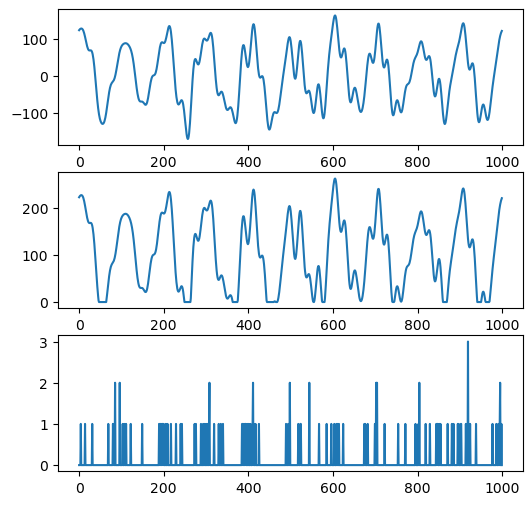

In [82]:
fig, ax = plt.subplots(3,1,figsize=(6,6))
trial = 1
for l in range (trial,trial+1):
    ax[0].plot(xs[:,0,l])
    ax[1].plot(cifs[:,0,l])
    ax[2].plot(obs[:,0,l])

In [33]:
def load_old(ov2, mu=0.0, K=2, L=25, sample_length=1000, C=1, ov1=1.0, seed=8, etype="approx", hess_mod=False):
    exp_path = '/projectnb/stephenlab/jtauber/cohlib/experiments/gaussian_observations'
    ov2 = float(ov2)
    if hess_mod is True:
        model_path = f'{exp_path}/saved/fitted_models/scale_hess_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)
    else:
        model_path = f'{exp_path}/saved/fitted_models/scale_mod_jax_comp_simple_synthetic_gaussian_em20_{K}_{L}_{sample_length}_{C}_{mu}_{ov1}_{ov2}_{seed}_fitted_{etype}.pkl'
        model_load = pickle_open(model_path)

    return model_load

dummy = -1 
old_model_load = load_old(dummy)
Wv = old_model_load['Wv']

In [17]:
# res_load_ts_oldmod_scipy.keys()
res_load.keys()

dict_keys([-1, 0, 2, 1])

In [18]:
ov2 = 1
r = 0
j = 19 
res_load_ts_oldmod_deconmod[ov2]['track'].track_em_data.keys()
res_load_ts_oldmod_scipy[ov2]['track'][0][r]['Sig_complex'][0,j,:,:]

array([[ 9875.08729613   +0.j        , -1836.56777639+2109.65611099j],
       [-1836.56777639-2109.65611099j, 19540.66817424   +0.j        ]])

In [19]:
# res_load[ov2]['params']

In [20]:
def sample_obs(gamma, result):
    cfg = result['cfg']
    lcfg = cfg['latent']
    ocfg = cfg['obs']

    lrk = jr.key(lcfg.seed)
    ork = jr.key(ocfg.seed)
    L = lcfg.L
    ov1 = ocfg.ov1
    ov2 = ocfg.ov2
    obs_var = ov1 * 10**ov2

    zs = sample_from_gamma(lrk, gamma, L)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    obs = xs + jr.normal(ork, xs.shape)*jnp.sqrt(obs_var)

    return obs

def sample_obs_for_qfunc_mc(gamma_r, result, M, mc_ork=0):
    "assumes gamma is complex"

    
    cfg = result['cfg']
    lcfg = cfg['latent']
    ocfg = cfg['obs']

    lrk = jr.key(lcfg.seed)
    L = lcfg.L
    ov1 = ocfg.ov1
    ov2 = ocfg.ov2
    obs_var = ov1 * 10**ov2



    if gamma_r.shape[0] < result['gamma_true_full'].shape[0]:
        nz = result['params']['nonzero_inds']
        gamma_temp = jnp.zeros_like(result['gamma_true_full'])
        gamma_temp = gamma_temp.at[nz,:,:].set(gamma_r)
        gamma_r = gamma_temp

    zs = sample_from_gamma(lrk, gamma_r, L)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    rk_split = jr.split(mc_ork, M)

    obs_mc_samples = [xs + jr.normal(rk_split[i], xs.shape)*jnp.sqrt(obs_var) for i in range(M)]

    return obs_mc_samples



In [21]:
from cohlib.conv import reverse_rearrange_mat
def transform_mat_c2r(complex_mat):
    """
    Convert matariance matrix from complex-valued to real-valued.
    """
    dim = complex_mat.shape[0]
    A = jnp.real(complex_mat)
    B = jnp.imag(complex_mat)
    rmat = jnp.zeros((2 * dim, 2 * dim))

    rmat = jnp.block([[A, -B], [B, A]])

    return rmat 

def transform_cov_c2r(complex_cov):
    return transform_mat_c2r(complex_cov) / 2

def transform_inv_cov_c2r(complex_inv_cov):
    return 2*transform_mat_c2r(complex_inv_cov)

def quick_conv_cov_c2r(ccov, K):
    return reverse_rearrange_mat(transform_cov_c2r(ccov), K)

def quick_conv_inv_cov_c2r(ccov, K):
    return reverse_rearrange_mat(transform_inv_cov_c2r(ccov), K)

def transform_cov_r2c(real_cov):
    """
    Convert covariance matrix from real-valued to complex-valued.
    """
    dimR = real_cov.shape[0]
    dimC = int(dimR / 2)
    ccov = jnp.zeros((dimC, dimC), dtype=complex)

    A = real_cov[:dimC, :dimC]
    B = real_cov[:dimC, dimC:]
    C = real_cov[dimC:, :dimC]
    D = real_cov[dimC:, dimC:]

    ccov = (A + D) + 1j * (C - B)

    return ccov

In [22]:
ov2 = 1
r = 1
track_jax = res_load[ov2]['track']
mus_jax = track_jax['mus'][r]
Upss_jax = track_jax['Upss'][r]
gamma_jax = track_jax['gamma'][r]

In [23]:
# len(track_oldfixts.track_em_data['mus'])

In [139]:
track_oldfixts = res_load_ts_oldmod_deconmod[ov2]['track']
mus_oldfixts = track_oldfixts.track_em_data['mus'][r]
Upss_oldfixts = track_oldfixts.track_em_data['Upss'][r]
gamma_oldfixts = track_oldfixts.track_em_data['gamma'][r]

In [140]:
k = 0
l = 0
print(mus_jax[:10,k,l])
print(mus_oldfixts[:10,k,l])

[  28.595516  -0.2950152j    2.0436826 +5.607568j
  -70.03599   +5.100563j  -106.2379   -29.794266j
    2.1477633+52.855984j    47.145756  -3.8476298j
    5.7600102+52.972378j    -2.2009122+60.10031j
  -36.68454  -81.36293j     37.040028  +9.374402j ]
[  28.809765  -0.21099554j    1.7175272 +5.607074j
  -70.429436  +5.131944j   -105.34483  -29.390892j
    4.4346337+53.373672j     48.3889    -3.8610663j
    6.189449 +52.925236j     -1.5613447+57.57199j
  -34.642788 -83.18519j      40.040436  +9.63187j   ]


In [ ]:
Up

In [141]:
print(Upss_jax[:10,k,k,l])
print(Upss_oldfixts[:10,k,k,l])

[2694.4502+1.2256460e-05j 2898.09  -1.8682513e-06j
 2732.8394-2.2348588e-07j 2830.9165+1.8279137e-05j
 2773.7341-3.7374550e-06j 2732.1409+1.1590610e-05j
 2890.8264-4.7579792e-06j 3008.5017-7.1043371e-07j
 3034.3667-7.5834696e-06j 2991.1726-8.3515861e-06j]
[2705.7336+1.8627481e-05j 2907.2815-1.2679777e-06j
 2745.1653-1.1248541e-06j 2846.7058-6.9766552e-06j
 2789.0898-5.6451681e-06j 2736.725 -7.5722312e-07j
 2901.2568-3.0007204e-06j 3011.4417+3.3065064e-06j
 3048.268 -3.0423864e-06j 3009.482 +3.9961396e-06j]


In [117]:
# jkkl
Upss_jax.shape

(50, 2, 2, 50)

In [118]:
#l,jk*jk
track_scipy[0]['Ups_invs'].shape

# so need block diag ([JxJ], [JxJ], ... [JxJ]) length K

(50, 200, 200)

In [124]:
nJ = 100
track_scipy = res_load_ts_old_scipy[ov2]['track'][0]
mus_scipy = track_scipy[r]['mus']
Ups_invs_scipy = track_scipy[r]['Ups_invs']


In [125]:
k = 0
l = 0

In [ ]:

print(mus_scipy[l,k*nJ:k*nJ+nJ])
print(mus_scipy[l,k*nJ:k*nJ+nJ])

In [126]:

print(mus_scipy[l,k*nJ:k*nJ+nJ])
print(mus_scipy[l,k*nJ:k*nJ+nJ])

[ 27.61513541  -7.79788233   1.28925808  -4.4442593  -55.35895964
 -15.73029165 -64.33779497 -23.2190428  -21.30972224  29.26788256
  38.58611267   3.16068017   2.56397716  27.51277447   6.63481081
  36.53065047 -11.91894446 -38.43477219  33.51971369  -2.02519922
  51.33455767 -11.4340367   14.26427687  10.8451976    0.60841493
  -1.66034865  29.88145473   4.89386185 -23.80702244  58.30080706
   4.90921738 -38.02894132   7.4149016  -11.14190831  44.78464595
  19.6381443  -25.38814686 -10.02999774  -8.89485523  -9.6379439
  27.72488173  -2.49209767  54.01769653 -17.97445636  -5.009632
   9.15556351 -21.18541944 -56.58350069  42.59605565  40.45981041
   9.396753    24.43675487 -17.58404593  -1.59324527  -8.05961295
  -7.78581777  18.15141831 -15.02218528  30.53435246  -5.55735197
 -42.79940284 -37.00710175 -35.40708598 -18.85459284   1.4395303
 -12.76309012  42.79080188  12.03641111   1.05708295  11.02056971
  20.9637276   45.66785898 -58.18540757   0.7555104    6.83447801
  -4.79080488 

In [121]:
# Ups_invs_scipy[l,k*num_J_vars,k*num_J_vars]
print(Upss_jax[0,k,k,l])
1/jnp.diag(Ups_invs_scipy[l,:,:])

(258.07916+1.2520649e-06j)


Array([452.4467 , 450.8213 , 462.8892 , 461.18835, 453.96173, 452.32608,
       457.16956, 455.5112 , 456.89975, 455.24387, 458.1792 , 456.51474,
       456.82004, 455.1663 , 468.78564, 467.04532, 457.39783, 455.742  ,
       461.8674 , 460.18042, 459.29492, 457.62793, 464.3733 , 462.67087,
       455.97113, 454.3313 , 460.64307, 458.97128, 466.78958, 465.07486,
       456.13837, 454.5029 , 460.06802, 458.4065 , 450.0228 , 448.435  ,
       459.64108, 457.98734, 453.32556, 451.7193 , 453.7655 , 452.15878,
       463.69702, 462.02216, 453.7616 , 452.16037, 456.7628 , 455.14343,
       461.9765 , 460.3234 , 465.35226, 463.67816, 457.3645 , 455.7506 ,
       448.1144 , 446.56842, 461.15298, 459.5196 , 457.2569 , 455.65463,
       463.11923, 461.4796 , 463.60715, 461.96835, 457.3971 , 455.80585,
       460.19077, 458.58432, 463.31372, 461.68994, 455.47397, 453.909  ,
       461.47336, 459.8717 , 462.15912, 460.55753, 466.01416, 464.3907 ,
       449.21527, 447.71136, 449.77176, 448.26898, 

In [ ]:
def get_Qs_real_jax(data, model_load, M, Wv):
    Qs = []
    # TODO option to add init as gamma_0
    # gamma_init = model_load['gamma_init']

    track = model_load['track'][0]
    em_iters = len(track)

    ocfg = model_load['cfg']['obs']
    ov1 = ocfg.ov1
    ov2 = ocfg.ov2
    obs_var = ov1 * 10**ov2

    As = []
    Bs = []
    for r in range(1, em_iters):
        # print(r)
        gamma_r = track[r-1]['gamma_rplus1']
        J = gamma_r.shape[0]
        # gamma_r_inv = jnp.stack([jnp.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
        gamma_r_inv = jnp.linalg.inv(gamma_r)
        sig_r = track[r]['Sig_complex']
        mus_r = track[r]['mus']
        Ups_invs_r = track[r]['Ups_invs']

        gamma_real_r = jnp.stack([quick_conv_cov_c2r(gamma_r[j,:,:],K) for j in range(J)])
        gamma_real_r_inv = jnp.stack([quick_conv_inv_cov_c2r(gamma_r_inv[j,:,:],K) for j in range(J)])

        sig_real_r = jnp.zeros((L,J,2*K,2*K))
        for l in range(L):
            sig_real_rl = jnp.stack([quick_conv_cov_c2r(sig_r[l,j,:,:],K) for j in range(J)])
            sig_real_r = sig_real_r.at[l,:,:,:].set(sig_real_rl)


        # A, B, Q = Q_func_real(gamma_real_r, gamma_real_r_inv, sig_real_r)
        A, B, Q = Q_func_jax(mus_jax_r, Ups_jax_r, M, gamma__r, gamma_real_r_inv, sig_real_r, Wv, obs_var, data)
        Qs.append(Q)
        As.append(A)
        Bs.append(B)

    # return jnp.array(Qs) 
    return As, Bs, jnp.array(Qs) 


In [68]:
def Q_func_mixed_scipy(mus_r, Ups_invs_r, M, Gamma_complex_r, Gamma_complex_r_inv, Sigmas_complex_r, Wv, obs_var, data):
    num_J_vars = Wv.shape[1]
    data = data.squeeze()
    L = Sigmas_complex_r.shape[0]
    K = data.shape[1]
    # print(K)
    # xs_post_samples = jnp.zeros((M, L, K, Wv.shape[0]))
    T = Wv.shape[0]
    xs_post_samples = jnp.zeros((T, K, L, M))

    for l in range(L):
        if l % 10 == 0:
            print(l)
        mu_l = mus_r[l,:]
        Ups_inv_l = Ups_invs_r[l,:,:]
        # Ups_l = jnp.diag(-1/jnp.diag(Ups_inv_l))
        # TODO why was this negative earlier? fixed bad naming convention in code?
        Ups_l = jnp.diag(1/jnp.diag(Ups_inv_l))
        posterior_samples = jnp.stack([jr.multivariate_normal(jr.key(l + m), mu_l, Ups_l) for m in range(M)])
        # print(posterior_samples.shape)
        # print(posterior_samples.shape)
        for m in range(M):
            for k in range(K):
                v_k = posterior_samples[m,k*num_J_vars:k*num_J_vars+num_J_vars]
                # print(v_k.shape)
                xs_post_samples = xs_post_samples.at[:,k,l,m].set(Wv @ v_k)

    # data - tkl 
    # xs_ps - tklm
    # A = suml sumk -2 y_kl.T @ invQ @ xs_kl
    # B = suml sumk xs_kl.T @ invQ @ xs_kl
    # then avg over M
    Qxs_ps = (1/obs_var) * xs_post_samples #(tklm)
    obsQ_sumA_mcsamps = -2 * jnp.einsum('tkl,tklm->klm', data, Qxs_ps).sum((0,1))
    obsQ_sumB_mcsamps = jnp.einsum('tklm,tklm->klm', xs_post_samples, Qxs_ps).sum((0,1))


    obsQ_mcsamps = obsQ_sumA_mcsamps + obsQ_sumB_mcsamps
    obsQ_mcmean = obsQ_mcsamps.mean()

    latentQ_sumA = L*( ((K)*jnp.log(jnp.pi) + jnp.log(jnp.linalg.det(Gamma_complex_r)))).sum()
    # sum_A = L*jnp.log(2*jnp.pi**K * (1/jnp.linalg.det(Gamma_real_r_inv))).sum()
    latentQ_sumB = jnp.trace(Gamma_complex_r_inv @ Sigmas_complex_r, axis1=2, axis2=3).sum()
    latentQ = -(latentQ_sumA) + -(latentQ_sumB)

    Q = obsQ_mcmean + latentQ

    return obsQ_mcmean, latentQ, Q

In [65]:
def get_Qs_mixed_scipy(data, model_load, M, Wv):
    Qs = []
    # TODO option to add init as gamma_0
    # gamma_init = model_load['gamma_init']

    track = model_load['track'][0]
    em_iters = len(track)

    ocfg = model_load['cfg']['obs']
    ov1 = ocfg.ov1
    ov2 = ocfg.ov2
    obs_var = ov1 * 10**ov2

    As = []
    Bs = []
    for r in range(1, em_iters):
        # print(r)
        gamma_r = track[r-1]['gamma_rplus1']
        J = gamma_r.shape[0]
        # gamma_r_inv = jnp.stack([jnp.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
        gamma_r_inv = jnp.linalg.inv(gamma_r)
        sig_r = track[r]['Sig_complex']
        mus_r = track[r]['mus']
        Ups_invs_r = track[r]['Ups_invs']

        sig_real_r = jnp.zeros((L,J,2*K,2*K))
        for l in range(L):
            sig_real_rl = jnp.stack([quick_conv_cov_c2r(sig_r[l,j,:,:],K) for j in range(J)])
            sig_real_r = sig_real_r.at[l,:,:,:].set(sig_real_rl)


        # A, B, Q = Q_func_real(gamma_real_r, gamma_real_r_inv, sig_real_r)
        A, B, Q = Q_func_mixed_scipy(mus_r, Ups_invs_r, M, gamma_r, gamma_r_inv, sig_r, Wv, obs_var, data)
        Qs.append(Q)
        As.append(A)
        Bs.append(B)

    # return jnp.array(Qs) 
    return As, Bs, jnp.array(Qs) 


In [34]:
def get_Qs_real_scipy(data, model_load, M, Wv):
    Qs = []
    # TODO option to add init as gamma_0
    # gamma_init = model_load['gamma_init']

    track = model_load['track'][0]
    em_iters = len(track)

    ocfg = model_load['cfg']['obs']
    ov1 = ocfg.ov1
    ov2 = ocfg.ov2
    obs_var = ov1 * 10**ov2

    As = []
    Bs = []
    for r in range(1, em_iters):
        # print(r)
        gamma_r = track[r-1]['gamma_rplus1']
        J = gamma_r.shape[0]
        # gamma_r_inv = jnp.stack([jnp.linalg.inv(gamma_r[j,:,:]) for j in range(gamma_r.shape[0])])
        gamma_r_inv = jnp.linalg.inv(gamma_r)
        sig_r = track[r]['Sig_complex']
        mus_r = track[r]['mus']
        Ups_invs_r = track[r]['Ups_invs']

        gamma_real_r = jnp.stack([quick_conv_cov_c2r(gamma_r[j,:,:],K) for j in range(J)])
        gamma_real_r_inv = jnp.stack([quick_conv_inv_cov_c2r(gamma_r_inv[j,:,:],K) for j in range(J)])

        sig_real_r = jnp.zeros((L,J,2*K,2*K))
        for l in range(L):
            sig_real_rl = jnp.stack([quick_conv_cov_c2r(sig_r[l,j,:,:],K) for j in range(J)])
            sig_real_r = sig_real_r.at[l,:,:,:].set(sig_real_rl)


        # A, B, Q = Q_func_real(gamma_real_r, gamma_real_r_inv, sig_real_r)
        A, B, Q = Q_func_real_new(mus_r, Ups_invs_r, M, gamma_real_r, gamma_real_r_inv, sig_real_r, Wv, obs_var, data)
        Qs.append(Q)
        As.append(A)
        Bs.append(B)

    # return jnp.array(Qs) 
    return As, Bs, jnp.array(Qs) 


In [69]:
ov2 = 2
M = 20
gamma_true = res_load_ts_old_scipy[ov2]['gamma_true_full']
obs = sample_obs(gamma_true, res_load_ts_old_scipy[ov2])

result = res_load_ts_old_scipy[ov2]
test = get_Qs_mixed_scipy(obs, result, M, Wv)

0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40


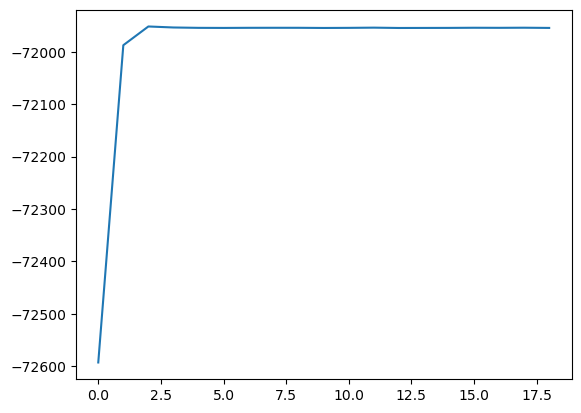

In [70]:
plt.plot(test[2])

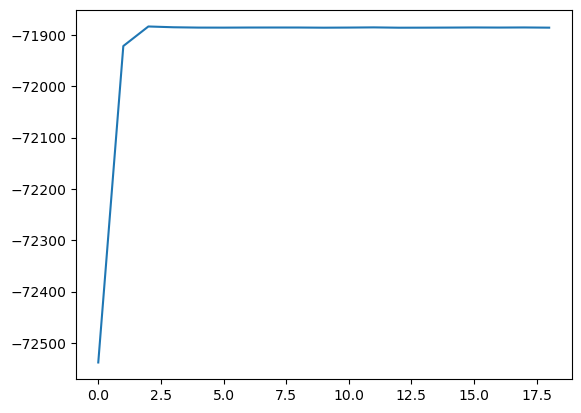

In [124]:

plt.plot(test[2])

In [125]:
M = 20
gamma_true = res_load_ts_oldmod_scipy[ov2]['gamma_true_full']
obs = sample_obs(gamma_true, res_load_ts_oldmod_scipy[ov2])

result = res_load_ts_oldmod_scipy[ov2]
test = get_Qs_real_scipy(obs, result, M, Wv)

0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40
0
10
20
30
40


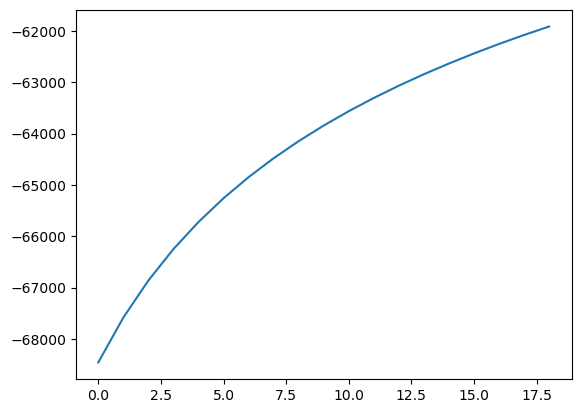

In [126]:
plt.plot(test[2])

yesssss... next do:
- jax - should be able to 
- repeat with single-target
- do multi-target and compare cross-specs
- identify bug / problem